## Problem Statement:
    
You are provided with 2 set of folders train and test. The train folder contains a single image and test folder contains 
15 images. We want you to analyse the images and put a classification based on distance difference. Use PYTHON as language 
to design the application.
1. Identify face from each image
2. Extract features from the face using the Google's Facenet model
3. Calculate the distance (any distance which increase the accuracy based on a threshold value) between each 
image with the image in train folder
4. Find out the preprocessing steps which will reduce the initial distance
5. Again calculate the distance and make a report on how preprocessing reduces distance

In [1]:
from keras.models import Sequential
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.engine.topology import Layer
from keras.initializers import glorot_uniform
from keras import backend as K
#from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
from numpy import genfromtxt
import pandas as pd
import tensorflow as tf
from mtcnn.mtcnn import MTCNN #https://github.com/ipazc/mtcnn

from scipy import spatial
#from utils import *
from utils import LRN2D
import utils
#from inception_blocks_v2 import *

%load_ext autoreload
%autoreload 2
%matplotlib inline

Using TensorFlow backend.


In [2]:
'''
This functions converts passed image from BGR to RGB.
parameters:
img -> Image which is to be converted
returns: Converted image to RGB form.
'''
def convertToRGB(img): 
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [3]:
'''

'''
def detect_face(image): 

    #plot the image passed
    #plt.imshow(image, cmap='gray')
    #convert the test image to gray image as opencv face detector expects gray images
    gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    #plt.imshow(gray_img, cmap='gray')
    haar_face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    #let's detect multiscale (some images may be closer to camera than others) images
    faces = haar_face_cascade.detectMultiScale(gray_img, scaleFactor=1.2, minNeighbors=5);

    #print the number of faces found
    print('Faces found: ', len(faces))
    return faces

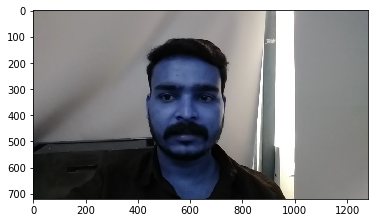

In [4]:
#load training iamge
train_image = cv2.imread('images/train/x.jpg')
#checking if the image is read
if(len(train_image) <= 0 ): print("Train image doesn't exist")
#ploting the image 
plt.imshow(train_image)

In [5]:
def image_to_embedding(image, model):
    #image = cv2.resize(image, (96, 96), interpolation=cv2.INTER_AREA) 
    image = cv2.resize(image, (96, 96)) 
    img = image[...,::-1]
    img = np.around(np.transpose(img, (0,1,2))/255.0, decimals=12)
    x_train = np.array([img])
    embedding = model.predict_on_batch(x_train)
    return embedding

# 1. Detection of Face
    I tried two techniques to detect faces in the image and compared their performances. 
## 1.1 Using Open CV Library Haar Cascade
    Below are the results of this.

Faces found:  1
Faces found:  0
Faces found:  0
Faces found:  0
Faces found:  1
Faces found:  0
Faces found:  1
Faces found:  0
Faces found:  1
Faces found:  1
Faces found:  1
Faces found:  0
Faces found:  0
Faces found:  0
Faces found:  0
Detect Accuracy:0.4


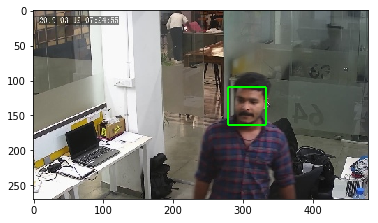

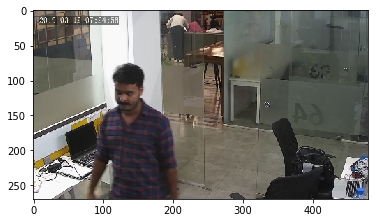

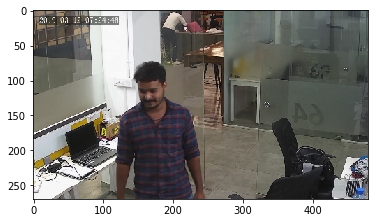

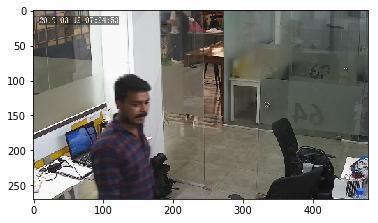

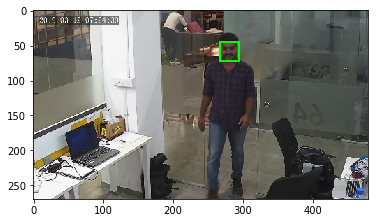

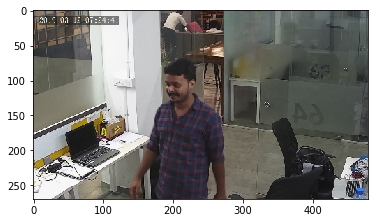

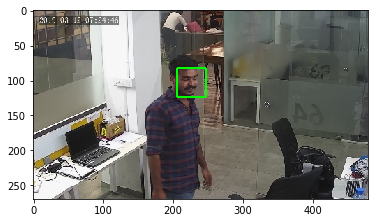

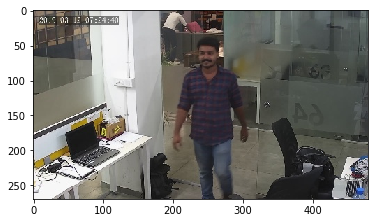

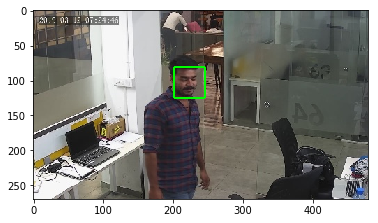

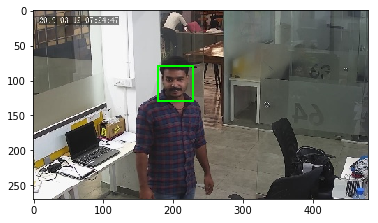

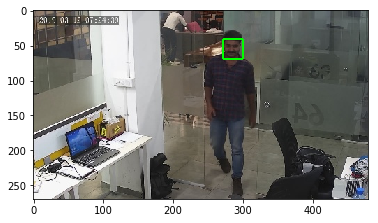

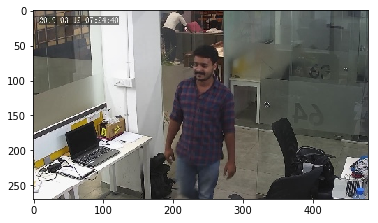

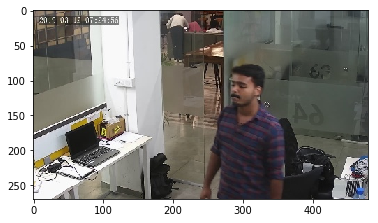

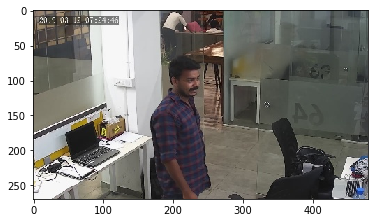

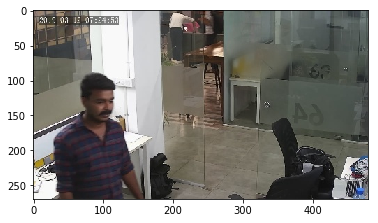

In [6]:
import glob
#says if face is detected
count = 0

test_images = [cv2.imread(file) for file in glob.glob("images/test/*.jpg")]
#Will be used in MTCNN face detection
test_images_mtcnn = test_images.copy()
for i in range(len( test_images )): 
    faces = detect_face(test_images[i] )
    #count increases if face is detected. 
    #Note that this can also detect faces which aren't actual faces so count mayn't always give appropriate accuracy
    if (len(faces) > 0): count= count +1  
    plt.figure()
    #draw rectangle if face is detected
    for (x, y, w, h) in faces:
        cv2.rectangle(test_images[i], (x, y), (x+w, y+h), (0, 255, 0), 2)
    #display the image with face detected (if)
    plt.imshow(convertToRGB(test_images[i]))
        
#Note that this can also detect faces which aren't actual faces so count mayn't always give appropriate accuracy regarding face detected
print("Detect Accuracy:" + str(count/len(test_images)))

Accuracy of face detection isn't very good.

## 1.2 Multi-task Cascaded Convolutional Networks (MTCNN) based Face Detection
 I have used an exising library for this.

### Finding faces on test and trains set 

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


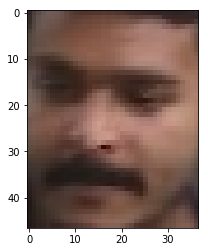

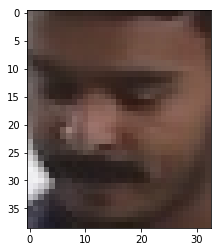

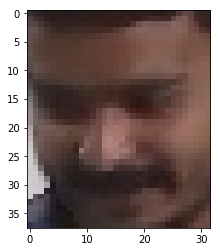

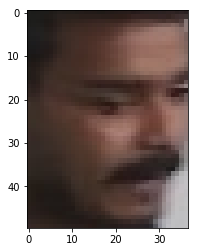

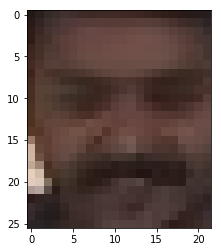

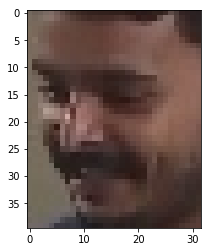

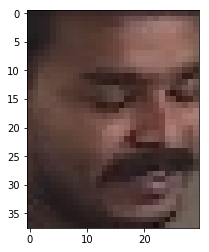

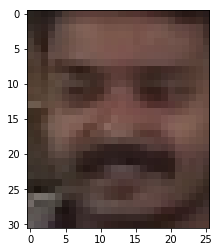

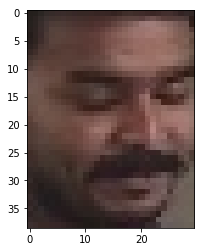

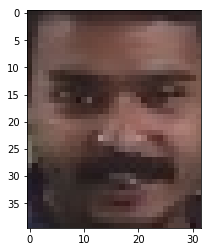

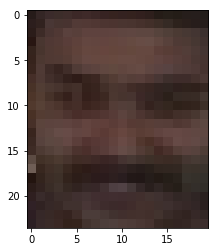

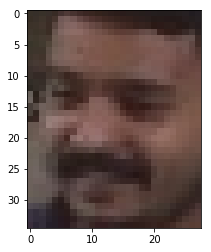

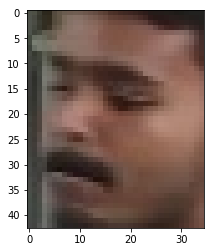

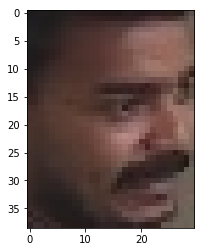

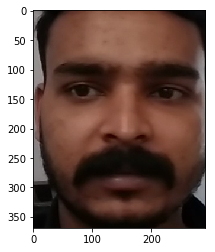

In [7]:
#will change it to deep copy to avoid expensive reread
images1 = [cv2.imread(file) for file in glob.glob("images/test/*.jpg")]

#stores cordinate of face detected
result = []
images_cropped = []
detector = MTCNN()
for i in range(len(images1)):
    plt.figure()
    result.append(detector.detect_faces(images1[i]))
    temp = result[i].copy()
    temp1 = images1[i].copy()
    (x, y, w, h) = temp[0]['box']
    #draw rectangle in first face detected
    #for i in range(1):
    #   cv2.rectangle(images1[i], (x, y), (x+w, y+h), (0, 255, 0), 2)
    #images_cropped.append(temp1[x:h,y:w])
    images_cropped.append(temp1[y:y+h,x:x+w].copy())
    plt.imshow(convertToRGB(images_cropped[i]))
#training image cropped
temp = detector.detect_faces(train_image)
temp1 = train_image.copy()
#temp1 = images1[i].copy()
(x, y, w, h) = temp[0]['box']
train_image_cropped = temp1[y:y+h,x:x+w]
plt.imshow(convertToRGB(train_image_cropped))

All the faces are correctly detected an cropped. Cropped images will be used later.

## 2. Running Model to Find the 1 X 128 encoding using FaceNet Model
   We are using transfer learning to use preexiting FaceNet model and weights.


In [8]:
myInput = Input(shape=(96, 96, 3))

x = ZeroPadding2D(padding=(3, 3), input_shape=(96, 96, 3))(myInput)
x = Conv2D(64, (7, 7), strides=(2, 2), name='conv1')(x)
x = BatchNormalization(axis=3, epsilon=0.00001, name='bn1')(x)
x = Activation('relu')(x)
x = ZeroPadding2D(padding=(1, 1))(x)
x = MaxPooling2D(pool_size=3, strides=2)(x)
x = Lambda(LRN2D, name='lrn_1')(x)
x = Conv2D(64, (1, 1), name='conv2')(x)
x = BatchNormalization(axis=3, epsilon=0.00001, name='bn2')(x)
x = Activation('relu')(x)
x = ZeroPadding2D(padding=(1, 1))(x)
x = Conv2D(192, (3, 3), name='conv3')(x)
x = BatchNormalization(axis=3, epsilon=0.00001, name='bn3')(x)
x = Activation('relu')(x)
x = Lambda(LRN2D, name='lrn_2')(x)
x = ZeroPadding2D(padding=(1, 1))(x)
x = MaxPooling2D(pool_size=3, strides=2)(x)

# Inception3a
inception_3a_3x3 = Conv2D(96, (1, 1), name='inception_3a_3x3_conv1')(x)
inception_3a_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_3x3_bn1')(inception_3a_3x3)
inception_3a_3x3 = Activation('relu')(inception_3a_3x3)
inception_3a_3x3 = ZeroPadding2D(padding=(1, 1))(inception_3a_3x3)
inception_3a_3x3 = Conv2D(128, (3, 3), name='inception_3a_3x3_conv2')(inception_3a_3x3)
inception_3a_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_3x3_bn2')(inception_3a_3x3)
inception_3a_3x3 = Activation('relu')(inception_3a_3x3)

inception_3a_5x5 = Conv2D(16, (1, 1), name='inception_3a_5x5_conv1')(x)
inception_3a_5x5 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_5x5_bn1')(inception_3a_5x5)
inception_3a_5x5 = Activation('relu')(inception_3a_5x5)
inception_3a_5x5 = ZeroPadding2D(padding=(2, 2))(inception_3a_5x5)
inception_3a_5x5 = Conv2D(32, (5, 5), name='inception_3a_5x5_conv2')(inception_3a_5x5)
inception_3a_5x5 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_5x5_bn2')(inception_3a_5x5)
inception_3a_5x5 = Activation('relu')(inception_3a_5x5)

inception_3a_pool = MaxPooling2D(pool_size=3, strides=2)(x)
inception_3a_pool = Conv2D(32, (1, 1), name='inception_3a_pool_conv')(inception_3a_pool)
inception_3a_pool = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_pool_bn')(inception_3a_pool)
inception_3a_pool = Activation('relu')(inception_3a_pool)
inception_3a_pool = ZeroPadding2D(padding=((3, 4), (3, 4)))(inception_3a_pool)

inception_3a_1x1 = Conv2D(64, (1, 1), name='inception_3a_1x1_conv')(x)
inception_3a_1x1 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_1x1_bn')(inception_3a_1x1)
inception_3a_1x1 = Activation('relu')(inception_3a_1x1)

inception_3a = concatenate([inception_3a_3x3, inception_3a_5x5, inception_3a_pool, inception_3a_1x1], axis=3)

# Inception3b
inception_3b_3x3 = Conv2D(96, (1, 1), name='inception_3b_3x3_conv1')(inception_3a)
inception_3b_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_3x3_bn1')(inception_3b_3x3)
inception_3b_3x3 = Activation('relu')(inception_3b_3x3)
inception_3b_3x3 = ZeroPadding2D(padding=(1, 1))(inception_3b_3x3)
inception_3b_3x3 = Conv2D(128, (3, 3), name='inception_3b_3x3_conv2')(inception_3b_3x3)
inception_3b_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_3x3_bn2')(inception_3b_3x3)
inception_3b_3x3 = Activation('relu')(inception_3b_3x3)

inception_3b_5x5 = Conv2D(32, (1, 1), name='inception_3b_5x5_conv1')(inception_3a)
inception_3b_5x5 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_5x5_bn1')(inception_3b_5x5)
inception_3b_5x5 = Activation('relu')(inception_3b_5x5)
inception_3b_5x5 = ZeroPadding2D(padding=(2, 2))(inception_3b_5x5)
inception_3b_5x5 = Conv2D(64, (5, 5), name='inception_3b_5x5_conv2')(inception_3b_5x5)
inception_3b_5x5 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_5x5_bn2')(inception_3b_5x5)
inception_3b_5x5 = Activation('relu')(inception_3b_5x5)

inception_3b_pool = Lambda(lambda x: x**2, name='power2_3b')(inception_3a)
inception_3b_pool = AveragePooling2D(pool_size=(3, 3), strides=(3, 3))(inception_3b_pool)
inception_3b_pool = Lambda(lambda x: x*9, name='mult9_3b')(inception_3b_pool)
inception_3b_pool = Lambda(lambda x: K.sqrt(x), name='sqrt_3b')(inception_3b_pool)
inception_3b_pool = Conv2D(64, (1, 1), name='inception_3b_pool_conv')(inception_3b_pool)
inception_3b_pool = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_pool_bn')(inception_3b_pool)
inception_3b_pool = Activation('relu')(inception_3b_pool)
inception_3b_pool = ZeroPadding2D(padding=(4, 4))(inception_3b_pool)

inception_3b_1x1 = Conv2D(64, (1, 1), name='inception_3b_1x1_conv')(inception_3a)
inception_3b_1x1 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_1x1_bn')(inception_3b_1x1)
inception_3b_1x1 = Activation('relu')(inception_3b_1x1)

inception_3b = concatenate([inception_3b_3x3, inception_3b_5x5, inception_3b_pool, inception_3b_1x1], axis=3)

# Inception3c
inception_3c_3x3 = utils.conv2d_bn(inception_3b,
                                   layer='inception_3c_3x3',
                                   cv1_out=128,
                                   cv1_filter=(1, 1),
                                   cv2_out=256,
                                   cv2_filter=(3, 3),
                                   cv2_strides=(2, 2),
                                   padding=(1, 1))

inception_3c_5x5 = utils.conv2d_bn(inception_3b,
                                   layer='inception_3c_5x5',
                                   cv1_out=32,
                                   cv1_filter=(1, 1),
                                   cv2_out=64,
                                   cv2_filter=(5, 5),
                                   cv2_strides=(2, 2),
                                   padding=(2, 2))

inception_3c_pool = MaxPooling2D(pool_size=3, strides=2)(inception_3b)
inception_3c_pool = ZeroPadding2D(padding=((0, 1), (0, 1)))(inception_3c_pool)

inception_3c = concatenate([inception_3c_3x3, inception_3c_5x5, inception_3c_pool], axis=3)

#inception 4a
inception_4a_3x3 = utils.conv2d_bn(inception_3c,
                                   layer='inception_4a_3x3',
                                   cv1_out=96,
                                   cv1_filter=(1, 1),
                                   cv2_out=192,
                                   cv2_filter=(3, 3),
                                   cv2_strides=(1, 1),
                                   padding=(1, 1))
inception_4a_5x5 = utils.conv2d_bn(inception_3c,
                                   layer='inception_4a_5x5',
                                   cv1_out=32,
                                   cv1_filter=(1, 1),
                                   cv2_out=64,
                                   cv2_filter=(5, 5),
                                   cv2_strides=(1, 1),
                                   padding=(2, 2))

inception_4a_pool = Lambda(lambda x: x**2, name='power2_4a')(inception_3c)
inception_4a_pool = AveragePooling2D(pool_size=(3, 3), strides=(3, 3))(inception_4a_pool)
inception_4a_pool = Lambda(lambda x: x*9, name='mult9_4a')(inception_4a_pool)
inception_4a_pool = Lambda(lambda x: K.sqrt(x), name='sqrt_4a')(inception_4a_pool)
inception_4a_pool = utils.conv2d_bn(inception_4a_pool,
                                   layer='inception_4a_pool',
                                   cv1_out=128,
                                   cv1_filter=(1, 1),
                                   padding=(2, 2))
inception_4a_1x1 = utils.conv2d_bn(inception_3c,
                                   layer='inception_4a_1x1',
                                   cv1_out=256,
                                   cv1_filter=(1, 1))
inception_4a = concatenate([inception_4a_3x3, inception_4a_5x5, inception_4a_pool, inception_4a_1x1], axis=3)

#inception4e
inception_4e_3x3 = utils.conv2d_bn(inception_4a,
                                   layer='inception_4e_3x3',
                                   cv1_out=160,
                                   cv1_filter=(1, 1),
                                   cv2_out=256,
                                   cv2_filter=(3, 3),
                                   cv2_strides=(2, 2),
                                   padding=(1, 1))
inception_4e_5x5 = utils.conv2d_bn(inception_4a,
                                   layer='inception_4e_5x5',
                                   cv1_out=64,
                                   cv1_filter=(1, 1),
                                   cv2_out=128,
                                   cv2_filter=(5, 5),
                                   cv2_strides=(2, 2),
                                   padding=(2, 2))
inception_4e_pool = MaxPooling2D(pool_size=3, strides=2)(inception_4a)
inception_4e_pool = ZeroPadding2D(padding=((0, 1), (0, 1)))(inception_4e_pool)

inception_4e = concatenate([inception_4e_3x3, inception_4e_5x5, inception_4e_pool], axis=3)

#inception5a
inception_5a_3x3 = utils.conv2d_bn(inception_4e,
                                   layer='inception_5a_3x3',
                                   cv1_out=96,
                                   cv1_filter=(1, 1),
                                   cv2_out=384,
                                   cv2_filter=(3, 3),
                                   cv2_strides=(1, 1),
                                   padding=(1, 1))

inception_5a_pool = Lambda(lambda x: x**2, name='power2_5a')(inception_4e)
inception_5a_pool = AveragePooling2D(pool_size=(3, 3), strides=(3, 3))(inception_5a_pool)
inception_5a_pool = Lambda(lambda x: x*9, name='mult9_5a')(inception_5a_pool)
inception_5a_pool = Lambda(lambda x: K.sqrt(x), name='sqrt_5a')(inception_5a_pool)
inception_5a_pool = utils.conv2d_bn(inception_5a_pool,
                                   layer='inception_5a_pool',
                                   cv1_out=96,
                                   cv1_filter=(1, 1),
                                   padding=(1, 1))
inception_5a_1x1 = utils.conv2d_bn(inception_4e,
                                   layer='inception_5a_1x1',
                                   cv1_out=256,
                                   cv1_filter=(1, 1))

inception_5a = concatenate([inception_5a_3x3, inception_5a_pool, inception_5a_1x1], axis=3)

#inception_5b
inception_5b_3x3 = utils.conv2d_bn(inception_5a,
                                   layer='inception_5b_3x3',
                                   cv1_out=96,
                                   cv1_filter=(1, 1),
                                   cv2_out=384,
                                   cv2_filter=(3, 3),
                                   cv2_strides=(1, 1),
                                   padding=(1, 1))
inception_5b_pool = MaxPooling2D(pool_size=3, strides=2)(inception_5a)
inception_5b_pool = utils.conv2d_bn(inception_5b_pool,
                                   layer='inception_5b_pool',
                                   cv1_out=96,
                                   cv1_filter=(1, 1))
inception_5b_pool = ZeroPadding2D(padding=(1, 1))(inception_5b_pool)

inception_5b_1x1 = utils.conv2d_bn(inception_5a,
                                   layer='inception_5b_1x1',
                                   cv1_out=256,
                                   cv1_filter=(1, 1))
inception_5b = concatenate([inception_5b_3x3, inception_5b_pool, inception_5b_1x1], axis=3)

av_pool = AveragePooling2D(pool_size=(3, 3), strides=(1, 1))(inception_5b)
reshape_layer = Flatten()(av_pool)
dense_layer = Dense(128, name='dense_layer')(reshape_layer)
norm_layer = Lambda(lambda  x: K.l2_normalize(x, axis=1), name='norm_layer')(dense_layer)


# Final Model
model = Model(inputs=[myInput], outputs=norm_layer)

In [9]:
# Load weights from csv files (which was exported from Openface torch model)
weights = utils.weights
weights_dict = utils.load_weights()

# Set layer weights of the model
for name in weights:
    if model.get_layer(name) != None:
        model.get_layer(name).set_weights(weights_dict[name])
    elif model.get_layer(name) != None:
        model.get_layer(name).set_weights(weights_dict[name])

In [10]:
##check if model is loaded properly
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 102, 102, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 48, 48, 64)   9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn1 (BatchNormalization)        (None, 48, 48, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

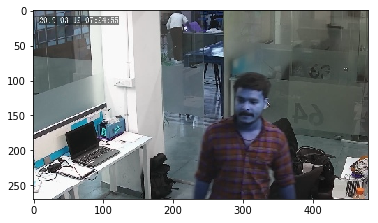

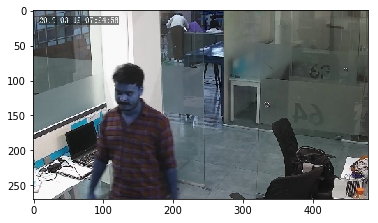

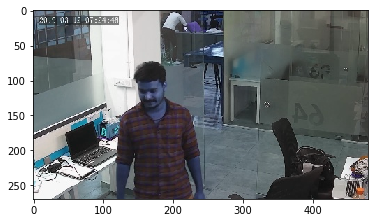

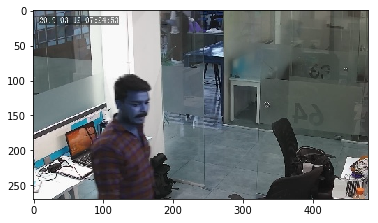

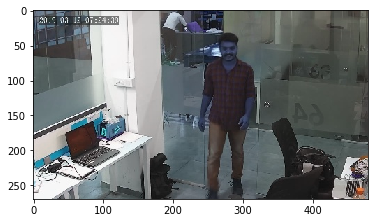

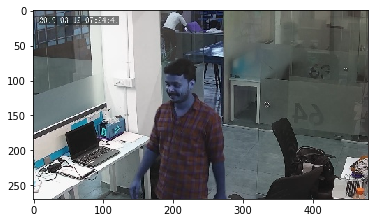

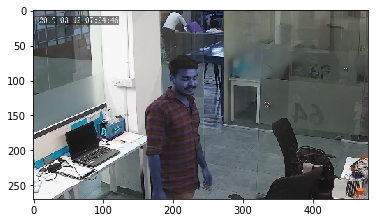

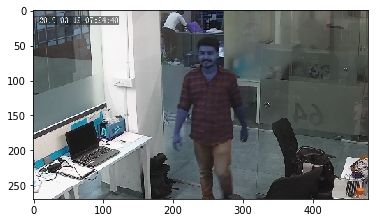

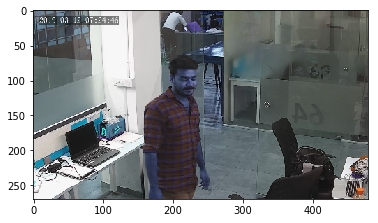

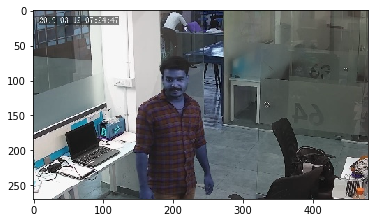

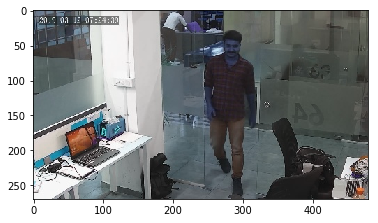

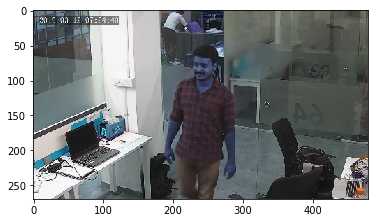

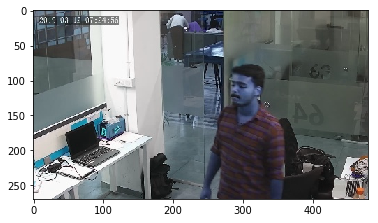

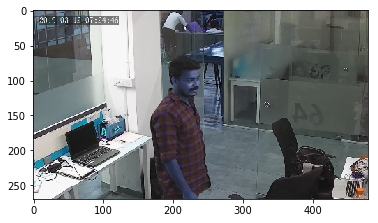

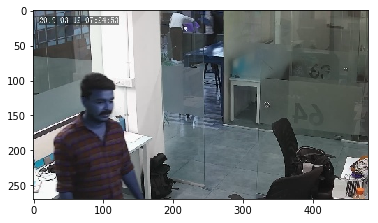

In [11]:
#Finding encodings of the test images.
#will change it to deep copy to avoid expensive reread
#we will use cropped train image
images_test = [cv2.imread(file) for file in glob.glob("images/test/*.jpg")] 
test_encoding= []
for i in range(len(images_test)):
    test_encoding.append( image_to_embedding(images_test[i], model ) )
    plt.figure()
    plt.imshow(images_test[i], cmap='gray')

In [12]:
#Returns cosine distance
def cosine(emb,test_encodings):
    #distance = 1 - spatial.distance.cosine(emb, test_encodings)
    distance = np.linalg.norm(emb - test_encodings)
    return distance

In [13]:
#returns euclidean distance
def euclideanDistance(emb,test_encodings):
    distance = np.linalg.norm(emb - test_encodings)
    return distance

In [14]:
#encoding for train image
train_image_encoding = image_to_embedding(train_image_cropped, model )

In [15]:
distance_test = []
count = 0
#faces = detect_face(images)
#i=0
for i in range(len(test_encoding)):
    distance_test.append(euclideanDistance(train_image_encoding,test_encoding[i]))
    #dis = distance[i]
    #print(dis)
    if(distance_test[i] < 0.9): 
        count =  count + 1
# len(distance)
print(distance_test)
preprocessed_accuracy = count/len(distance_test)
print("preprocessed accuracy: "+ str(preprocessed_accuracy))

[1.3656704, 1.2476997, 1.3072658, 1.1828008, 1.4257998, 1.2669472, 1.147613, 1.3071253, 1.1412948, 1.2661428, 1.4132316, 1.2583504, 1.3775476, 1.2068614, 1.2928687]
preprocessed accuracy: 0.0


Detection accuracy is just 66.66% so we will perform some preprocessing to reduce distance.
## 3. Peforming Preprocessing
 We will try various preprocessing techniques and see what works for this problem.

### 3.1 Cropping Image
 As we are detecting faces all impormation except face isn't useful for us so we will just crop them out. 
 We already have croped images so we will directlt be using those to calculate distance.

In [16]:
#finding encodings of cropped image
#stores encoding of croped images
images_cropped_encodings = []
images_cropped_distance = []
for i in range(len(images_cropped)): 
    images_cropped_encodings.append( image_to_embedding(images_cropped[i], model ) )
    images_cropped_distance.append(euclideanDistance(train_image_encoding,images_cropped_encodings[i]))
print("cropped Image Distance: "+ str(images_cropped_distance))
print("Normal Image Distance: "+ str(distance_test))
print(np.subtract(images_cropped_distance,distance_test))

cropped Image Distance: [0.6981215, 0.80034554, 0.9249159, 1.0987935, 0.7042653, 0.7701263, 0.8614062, 0.6942382, 0.6887169, 0.55388236, 0.8503005, 0.776826, 0.9689643, 1.018722, 0.8302695]
Normal Image Distance: [1.3656704, 1.2476997, 1.3072658, 1.1828008, 1.4257998, 1.2669472, 1.147613, 1.3071253, 1.1412948, 1.2661428, 1.4132316, 1.2583504, 1.3775476, 1.2068614, 1.2928687]
[-0.66754895 -0.4473542  -0.38234985 -0.08400726 -0.72153455 -0.49682087
 -0.28620684 -0.61288714 -0.45257795 -0.7122605  -0.5629311  -0.48152435
 -0.40858334 -0.18813932 -0.46259922]


The distance has decreased drastically.

## 3.2 Converting RGB to Grey
  As we convert the image to greyscale all he color imformation and noise due to difference in lighting etc is removed.

In [17]:
def image_to_embedding_processed(image, model):
    #image = cv2.resize(image, (96, 96), interpolation=cv2.INTER_AREA) 
    image = cv2.resize(image, (96, 96)) 
    img = image[...,::-1]
    img = np.around(np.transpose(img, (0,1,2))/255.0, decimals=12)
    x_train = np.array([img])
    embedding = model.predict_on_batch(x_train)
    return embedding

In [18]:
# importing copy module 
import copy 
grayscale_image = []
img = copy.deepcopy(images_cropped)
#print(len(grayscale_image))
for i in range(len(img)) :
    temp = cv2.cvtColor(img[i], cv2.COLOR_RGB2GRAY)
    grayscale_image.append(temp)
    print(grayscale_image[i].shape)

(47, 37)
(39, 33)
(38, 32)
(50, 37)
(26, 22)
(40, 32)
(38, 30)
(31, 26)
(39, 30)
(40, 32)
(24, 20)
(35, 28)
(43, 35)
(39, 30)
(48, 37)


In [19]:
#finding encodings of cropped image
#stores encoding of croped images
images_cropped_encodings_gray = []
images_cropped_distance_gray = []
print(len(grayscale_image))
for i in range(len(grayscale_image)):
    a = grayscale_image[i]
    #print(a.shape)
    b = np.repeat(a[:, :, np.newaxis], 3, axis=2)
    #print(b.shape)
    images_cropped_encodings_gray.append( image_to_embedding_processed(b, model ) )
    images_cropped_distance_gray.append(euclideanDistance(train_image_encoding,images_cropped_encodings_gray[i]))
print("cropped Image Distance: "+ str(images_cropped_distance_gray))
print("Normal Image Distance: "+ str(images_cropped_distance))
print(np.subtract(images_cropped_distance_gray,distance_test))
print(np.subtract(images_cropped_distance_gray,images_cropped_distance))

15
cropped Image Distance: [0.7820711, 0.80457896, 0.93582606, 1.1063809, 0.81174177, 0.95826083, 1.0008, 0.6932325, 0.70968235, 0.6067649, 0.8407012, 0.93640846, 0.98559254, 1.0139517, 0.8715648]
Normal Image Distance: [0.6981215, 0.80034554, 0.9249159, 1.0987935, 0.7042653, 0.7701263, 0.8614062, 0.6942382, 0.6887169, 0.55388236, 0.8503005, 0.776826, 0.9689643, 1.018722, 0.8302695]
[-0.5835993  -0.44312078 -0.3714397  -0.07641983 -0.6140581  -0.30868632
 -0.14681304 -0.61389285 -0.4316125  -0.65937793 -0.5725304  -0.3219419
 -0.39195508 -0.19290972 -0.42130393]
[ 0.08394963  0.00423342  0.01091015  0.00758743  0.10747647  0.18813455
  0.1393938  -0.00100571  0.02096546  0.05288255 -0.00959927  0.15958244
  0.01662827 -0.0047704   0.04129529]


In most of the cases the distance without converting image to grayscale is better.

## 3.3 Noise Removal using Gaussian Blur
 

In [20]:
image_noise_removed = []
img = copy.deepcopy(images_cropped)
for i in range(len(img)):
    blur = cv2.GaussianBlur(img[i], (25, 25), 0)
    image_noise_removed.append(blur)
    #print(image_noise_removed[i].shape)
print(len(image_noise_removed))

15


In [21]:
#finding distance after noise removal
#finding encodings of cropped image
#stores encoding of croped images
images_cropped_encodings_gaussian = []
images_cropped_distance_gaussian = []
#print(len(grayscale_image))
for i in range(len(image_noise_removed)):
    images_cropped_encodings_gaussian.append( image_to_embedding(image_noise_removed[i], model ) )
    images_cropped_distance_gaussian.append(euclideanDistance(train_image_encoding,images_cropped_encodings_gaussian[i]))
print("cropped Image Distance: "+ str(images_cropped_distance_gaussian))
print("Normal Image Distance: "+ str(images_cropped_distance))
print(np.subtract(images_cropped_distance_gaussian,distance_test))
print(np.subtract(images_cropped_distance_gaussian,images_cropped_distance))

cropped Image Distance: [1.2112535, 1.2774286, 1.2341843, 1.2380649, 1.227637, 1.237711, 1.2778714, 1.2022475, 1.2421659, 1.2142593, 1.2296342, 1.1784735, 1.2328402, 1.2506115, 1.2692993]
Normal Image Distance: [0.6981215, 0.80034554, 0.9249159, 1.0987935, 0.7042653, 0.7701263, 0.8614062, 0.6942382, 0.6887169, 0.55388236, 0.8503005, 0.776826, 0.9689643, 1.018722, 0.8302695]
[-0.15441692  0.02972889 -0.07308149  0.05526412 -0.1981628  -0.0292362
  0.13025832 -0.10487783  0.10087109 -0.05188358 -0.18359745 -0.0798769
 -0.14470744  0.04375017 -0.02356946]
[0.51313204 0.4770831  0.30926836 0.13927138 0.52337176 0.46758467
 0.41646516 0.5080093  0.55344903 0.6603769  0.37933367 0.40164745
 0.2638759  0.23188949 0.43902975]
